In [137]:
import re
import itertools
from itertools import islice, chain
import string
import sys  
import nltk
from nltk.corpus import stopwords
import pandas as pd
from pymystem3 import Mystem

import news_config as config
from NewsMongoMiner import NewsMongoHelper

#set encoding for Cyrillic
reload(sys)  
sys.setdefaultencoding('utf8')

%load_ext autoreload
%autoreload 2

In [138]:
#adds cyrillic to plot figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rc('font', family='DejaVu Sans')

In [153]:
mystem = Mystem()

mongo_helper = NewsMongoHelper()
news = mongo_helper.get_news(config.pravda_collection)
articles = [item['text'] for item in news]
len(news)

16379

In [177]:
stop_words = [u'', u' ', u'-', '\n', u'–', u'это', u'еще', u'него', u'сказать', u'а', u'ж', u'нее', u'со', u'без', u'же', u'ней', 
      u'совсем', u'более', u'жизнь', u'нельзя', u'так', u'больше', u'за', u'нет', 
      u'такой', u'будет', u'зачем', u'ни', u'там', u'будто', u'здесь', u'нибудь', u'тебя', 
      u'бы', u'и', u'никогда', u'тем', u'был', u'из', u'ним', u'теперь', u'была', u'из-за', 
      u'них', u'то', u'были', u'или', u'ничего', u'тогда', u'было', u'им', u'но', u'того', 
      u'быть', u'иногда', u'ну', u'тоже', u'в', u'их', u'о', u'только', u'вам', u'к', u'об', 
      u'том', u'вас', u'кажется', u'один', u'тот', u'вдруг', u'как', u'он', u'три', u'ведь', 
      u'какая', u'она', u'тут', u'во', u'какой', u'они', u'ты', u'вот', u'когда', u'опять', 
      u'у', u'впрочем', u'конечно', u'от', u'уж', u'все', u'которого', u'перед', u'уже', u'всегда', 
      u'которые', u'по', u'хорошо', u'всего', u'кто', u'под', u'хоть', u'всех', u'куда', u'после',
      u'чего', u'всю', u'ли', u'потом', u'человек', u'вы', u'лучше', u'потому', u'чем', u'г', u'между', 
      u'почти', u'через', u'где', u'меня', u'при', u'что', u'говорил', u'мне', u'про', u'чтоб', u'да', 
      u'много', u'раз', u'чтобы', u'даже', u'может', u'разве', u'чуть', u'два', u'можно', u'с', u'эти', 
      u'для', u'мой', u'сам', u'этого', u'до', u'моя', u'свое', u'этой', u'другой', u'мы', u'свою', 
      u'этом', u'его', u'на', u'себе', u'этот', u'ее', u'над', u'себя', u'эту', u'ей', u'надо', u'сегодня', 
      u'я', u'ему', u'наконец', u'сейчас', 'если', u'нас', 'есть', u'не', u'также']
    
stop_words = stop_words + nltk.corpus.stopwords.words('russian')
stop_words = list(set(stop_words))

punctuation_regex = re.compile('[%s]' % re.escape(string.punctuation))

def get_stop_words_from_tokens(tokens, threshold):
    tokens = pd.Series(tokens)
    token_frequencies = tokens.value_counts()
    return token_frequencies[token_frequencies < threshold].index.values.tolist()

def remove_punctuation(text):
    """ Remove single punctuation entry from tokens list """
    return punctuation_regex.sub('', text) 

def lemmatized_formatter(text):
    return [item.lower().strip() for item in mystem.lemmatize(text) if item.strip() not in [u'', u' ']]

def clean_formatter(text):
    text = remove_punctuation(text)
    lemmas = lemmatized_formatter(text)
    tokens = [lemma for lemma in lemmas if not lemma in stop_words]
    return tokens

def clean_text(text):
    tokens = clean_formatter(text)
    return ' '.join(tokens)

In [178]:
def get_tokens(articles, formatter):
    formatted = [formatter(entry) for entry in articles]
    joined = [' '.join(tokens) for tokens in formatted]  
    tokenized = [nltk.tokenize.word_tokenize(entry) for entry in joined]    
    tokens = [item for sublist in tokenized for item in sublist]
    return tokens
    
def get_ngrams(articles, formatter, ngram):
    text_tokens = [formatter(text) for text in articles]
    bigrams_generators = [nltk.ngrams(tokens, ngram) for tokens in text_tokens]
    bigrams_list = [list(bigrams) for bigrams in bigrams_generators]
    bigrams = [item for sublist in bigrams_list for item in sublist]
    return bigrams

def get_bigrams(articles, formatter):
    return get_ngrams(articles, formatter, 2)

def get_trigrams(articles, formatter):
    return get_ngrams(articles, formatter, 3)   

In [50]:
titles = [item['title'] for item in news]
title_bigrams = get_bigrams(titles, formatter_base)1
title_trigrams = get_trigrams(titles, formatter_base)

In [199]:
# article_tokens = get_tokens(articles, clean_formatter)
# article_bigrams = get_bigrams(articles, clean_formatter)
# article_trigrams = get_trigrams(articles, clean_formatter)

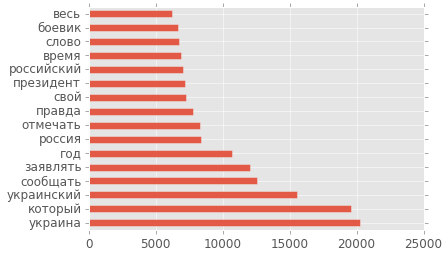

In [200]:
tokens = pd.Series(article_tokens).value_counts()
tokens[:16].plot(kind="barh", fontsize=12, alpha=0.9)
plt.savefig('plots/most_frequent_words.jpeg', format='jpeg', dpi=400, bbox_inches='tight')

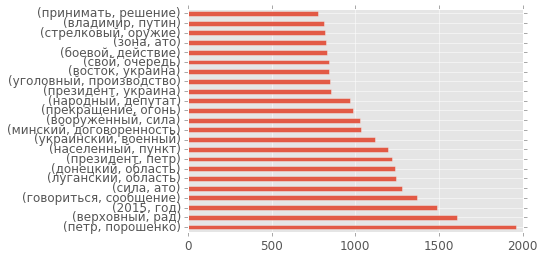

In [198]:
# bigrams = pd.Series(article_bigrams).value_counts()
bigrams[2:25].plot(kind="barh", fontsize=12, alpha=0.9)
plt.savefig('plots/most_frequent_bigrams_2.jpeg', format='jpeg', dpi=400, bbox_inches='tight')

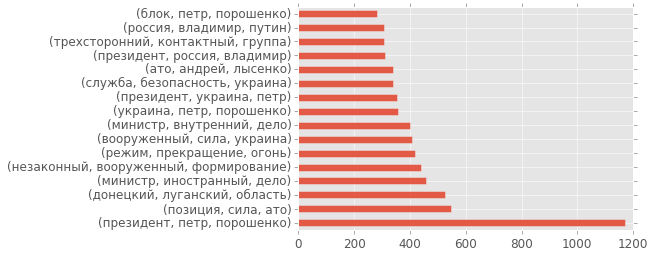

In [196]:
# trigrams = pd.Series(article_trigrams).value_counts()
trigrams[:16].plot(kind="barh", fontsize=12, alpha=0.9)
plt.savefig('plots/most_frequent_trigrams.jpeg', format='jpeg', dpi=400, bbox_inches='tight')